In [ ]:
!pip install pykalman
!pip install starfishX
!pip install mplfinance
!pip install yfinance
!pip install pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install matplotlib==3.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from scipy import poly1d
from datetime import datetime, date
import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline
import starfishX as sx

from scipy.stats.stats import pearsonr
import statsmodels.tsa.stattools as ts

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint

# Download a stock data from SET or US market. Choose some that are not the same as in our lectures. Choose at least a pair of stocks to implement pair trading with: 1. Linear regression; 2. Kalman filter

## Linear Regression

In [ ]:
ticker = 'BBL.BK KBANK.BK'

df = yf.download(ticker, start='2015-01-01', adjust=True)
df = df['Close'].copy()
df.head()

[*********************100%***********************]  2 of 2 completed


,BBL.BK,KBANK.BK
Date,,
2015-01-05,190.0,220.0
2015-01-06,189.5,214.0
2015-01-07,191.5,218.0
2015-01-08,192.0,228.0
2015-01-09,190.0,229.0


In [ ]:
print('Pearson correlation coefficient: %.7f' %(pearsonr(df["BBL.BK"], df["KBANK.BK"])[0]))

Pearson correlation coefficient: 0.9156942


In [ ]:
S1 = df['BBL.BK']
S2 = df['KBANK.BK']

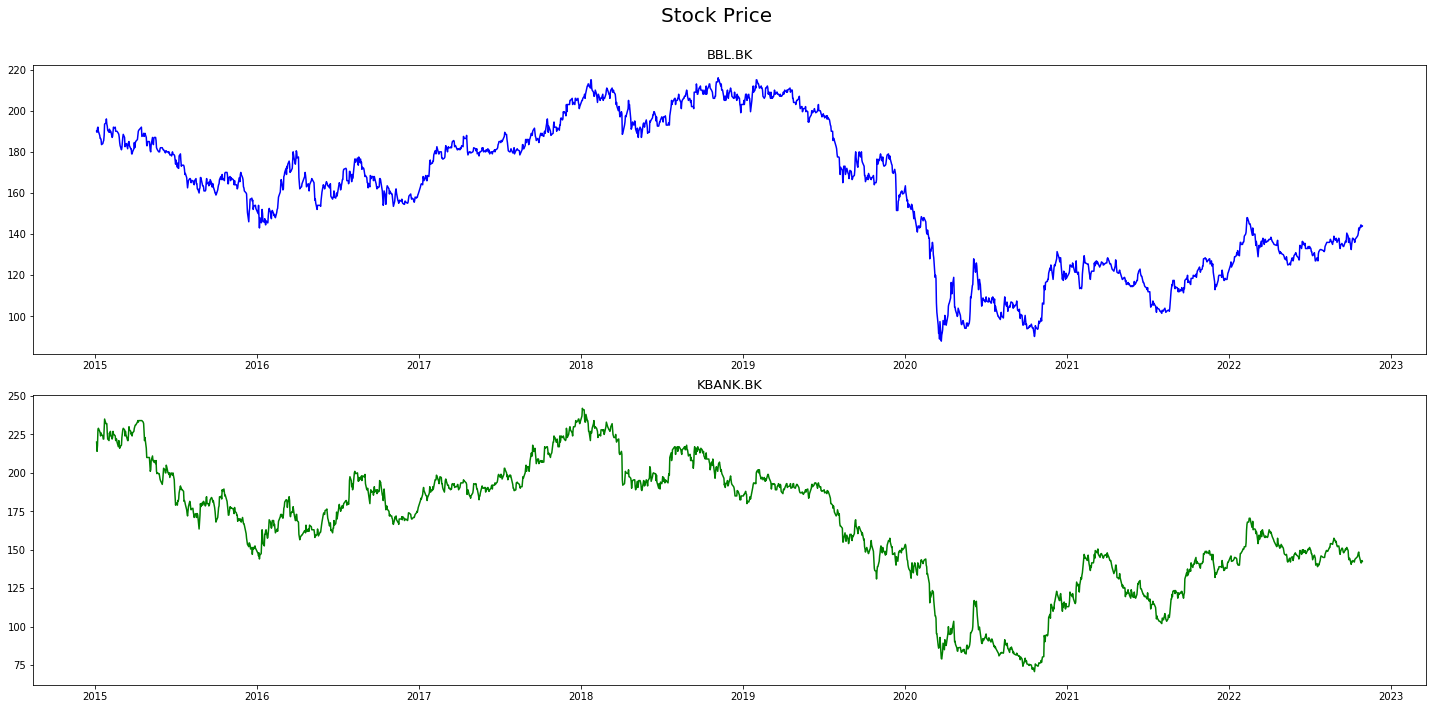

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(20,10))

fig.suptitle('Stock Price', size=20)

axes[0].plot(df['BBL.BK'], color='blue')
axes[0].set_title('BBL.BK', fontsize=13)

axes[1].plot(df['KBANK.BK'], color='green')
axes[1].set_title('KBANK.BK', fontsize=13)

plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

### Case 1: BBL.BK (X) and KBANK.BK (Y)

In [ ]:
reg1 = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
reg1.fit(df['BBL.BK'].values.reshape(-1,1), df['KBANK.BK'].values)
print('parameters: %.7f, %.7f' %(reg1.intercept_, reg1.coef_))

parameters: -2.6729355, 1.0556557


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


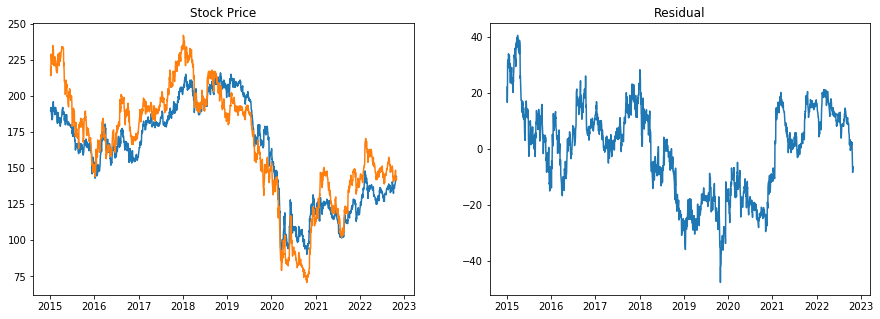

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set_title("Stock Price")
ax[0].plot(df)
yfit_1 = reg1.coef_ * df['BBL.BK'] + reg1.intercept_
res_1 = df['KBANK.BK'] - yfit_1
ax[1].set_title('Residual')
ax[1].plot(res_1)
plt.show()

In [ ]:
##### CADF #####
def adf_test(series):
    result = ts.adfuller(series, 1)
    # Format Output
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
          print('Critial Values:')
          print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

In [ ]:
adf_test(res_1)

ADF Statistic: -3.179594602341478
p-value: 0.02119662536766503
Critial Values:
   1%, -3.4337963982844437
Critial Values:
   5%, -2.8630623892170872
Critial Values:
   10%, -2.5675804623268697
Result: The series is stationary


### Case 2: KBANK.BK(X) & BBL.BK(Y)

In [ ]:
reg2 = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
reg2.fit(df['KBANK.BK'].values.reshape(-1,1), df['BBL.BK'].values)
print('parameters: %.7f, %.7f' %(reg2.intercept_, reg1.coef_))

parameters: 28.0969395, 1.0556557


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


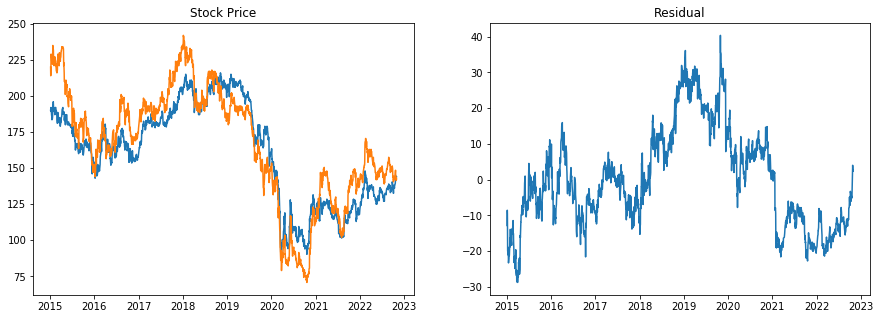

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set_title("Stock Price")
ax[0].plot(df)
yfit_2 = reg2.coef_ * df['KBANK.BK'] + reg2.intercept_
res_2 = df['BBL.BK'] - yfit_2
ax[1].set_title('Residual')
ax[1].plot(res_2)
plt.show()

In [ ]:
adf_test(res_2)

ADF Statistic: -3.0364108552406486
p-value: 0.03163117472161611
Critial Values:
   1%, -3.4337963982844437
Critial Values:
   5%, -2.8630623892170872
Critial Values:
   10%, -2.5675804623268697
Result: The series is stationary


## Trading

เนื่องจาก ADF Statistic test ของ case1 = -3.179594602341478 เเละ case 2 = -3.0364108552406486 จึงเลือก case 1 มาใช้ในการ trade เนื่องจาก case1 < case2 

In [ ]:
# CHECK COINTEGRATE
cont = coint(df['BBL.BK'], df['KBANK.BK'])
cont

(-2.7006207897585526,
 0.19935547203688836,
 array([-3.90221345, -3.33934773, -3.04668296]))

In [ ]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

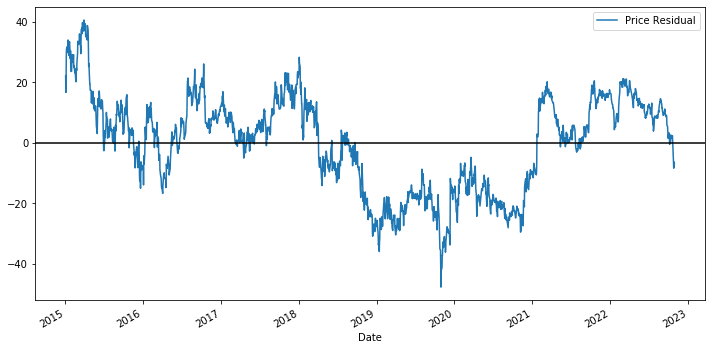

In [ ]:
res_1.plot(figsize=(12,6))
plt.axhline(res_1.mean(), color='black')
plt.legend(['Price Residual']);

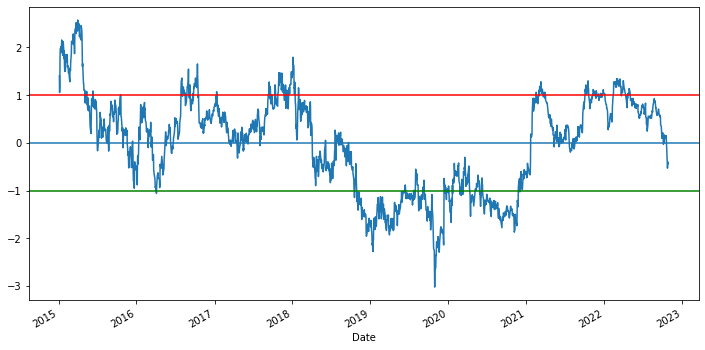

In [ ]:
zscore(res_1).plot(figsize=(12,6))
plt.axhline(zscore(res_1).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

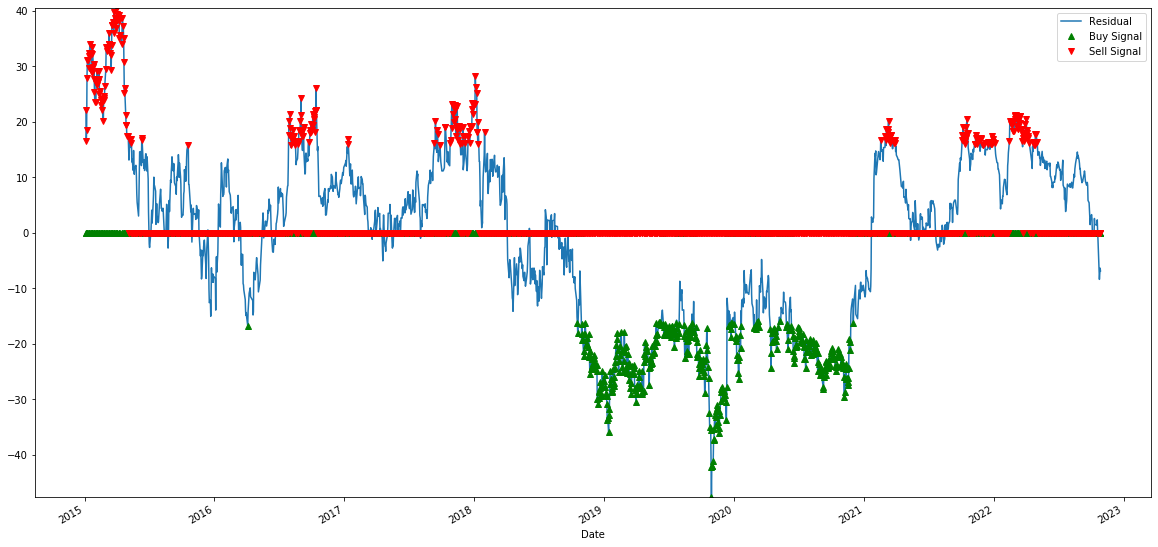

In [ ]:
res_1.plot(figsize=(20,10))
buy = res_1.copy()
sell = res_1.copy()
buy[zscore(res_1) > -1] = 0
sell[zscore(res_1) < 1] = 0
buy.plot(color="g", linestyle="None", marker="^")
sell.plot(color="r", linestyle="None", marker="v")
x1,x2,y1,y2 = plt.axis()
plt.axis((x1, x2, res_1.min(), res_1.max()))
plt.legend(["Residual", "Buy Signal", "Sell Signal"])
plt.show()

In [ ]:
KBANK_buy = df['KBANK.BK'].copy()
KBANK_sell = df['KBANK.BK'].copy()
BBL_buy = df['BBL.BK'].copy()
BBL_sell = df['BBL.BK'].copy()

In [ ]:
KBANK_p = df['KBANK.BK'].copy()
BBL_p = df['BBL.BK'].copy()

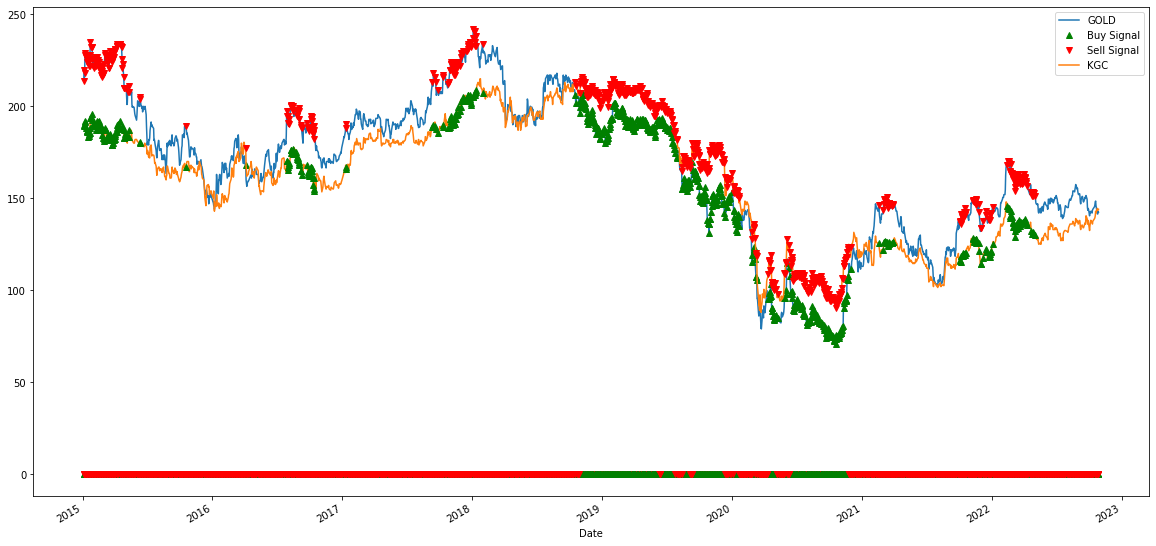

In [ ]:
KBANK_p.plot(figsize=(20, 10))
KBANK_buy[zscore(res_1) > -1] = 0
KBANK_sell[zscore(res_1) < 1] = 0
KBANK_buy.plot(color="g", linestyle="None", marker="^")
KBANK_sell.plot(color="r", linestyle="None", marker="v")

BBL_p.plot()
BBL_buy[zscore(res_1) < 1] = 0
BBL_sell[zscore(res_1) > -1] = 0
BBL_buy.plot(color="g", linestyle="None", marker="^")
BBL_sell.plot(color="r", linestyle="None", marker="v")

x1, x2, y1, y2 = plt.axis()
plt.legend(["GOLD", "Buy Signal", "Sell Signal", "KGC"])
plt.show()

In [ ]:
pair_corr_trade = pd.DataFrame(index=df['KBANK.BK'].index)
pair_corr_trade['KBANK_buy'] = np.zeros(len(df['KBANK.BK']))
pair_corr_trade['KBANK_sell'] = np.zeros(len(df['KBANK.BK']))
pair_corr_trade['BBL_buy'] = np.zeros(len(df['BBL.BK']))
pair_corr_trade['BBL_sell'] = np.zeros(len(df['BBL.BK']))
pair_corr_trade['delta'] = np.zeros(len(df['BBL.BK']))

In [ ]:
pos = 0
for i in range(len(KBANK_p)):
    kbank_pos = KBANK_p[i]
    bbl_pos = BBL_p[i] * int(kbank_pos/BBL_p[i])

    delta_pos = kbank_pos - bbl_pos
    if not pos and KBANK_buy[i] != 0:
        pair_corr_trade['KBANK_buy'][i] = kbank_pos
        pair_corr_trade['BBL_sell'][i] = bbl_pos
        pair_corr_trade['delta'][i] = delta_pos
        pos = 1
    elif not pos and KBANK_sell[i] != 0:
        pair_corr_trade['KBANK_sell'][i] = kbank_pos
        pair_corr_trade['BBL_buy'][i] = bbl_pos
        pair_corr_trade['delta'][i] = delta_pos
        pos = -1
    elif pos == -1 and (KBANK_sell[i] == 0 or i == len(KBANK_p) - 1):
        pair_corr_trade['KBANK_buy'][i] = kbank_pos
        pair_corr_trade['BBL_sell'][i] = bbl_pos
        pos = 0
    elif pos == 1 and (KBANK_buy[i] == 0 or i == len(KBANK_p) - 1):
        pair_corr_trade['KBANK_sell'][i] = kbank_pos
        pair_corr_trade['BBL_buy'][i] = bbl_pos
        pos = 0

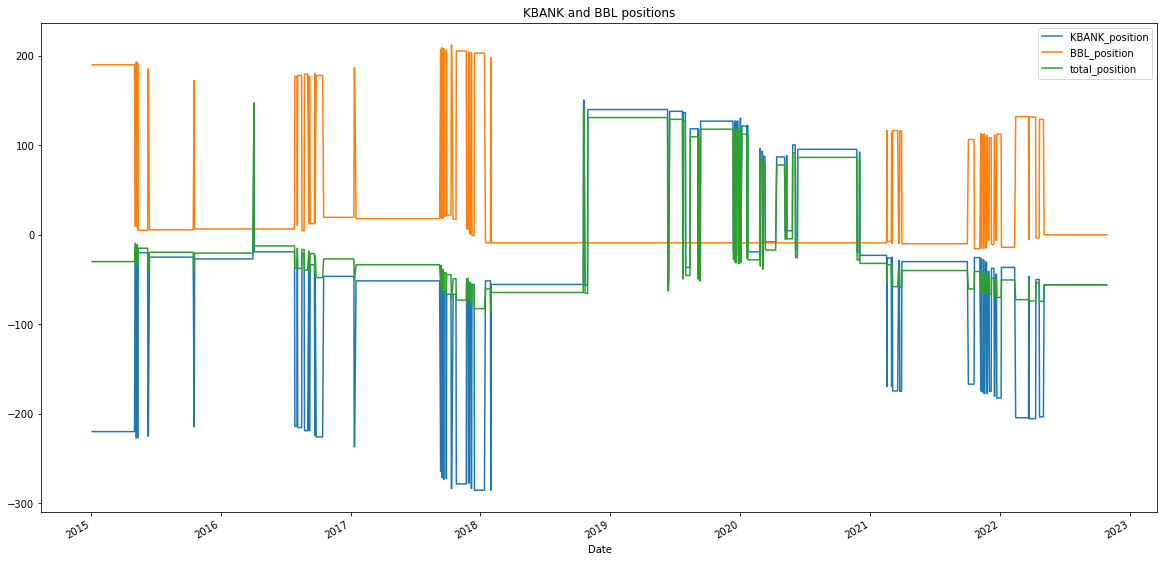

In [ ]:
pair_corr_trade['KBANK_position'] = pair_corr_trade['KBANK_buy'] - pair_corr_trade['KBANK_sell']

pair_corr_trade['BBL_position'] = pair_corr_trade['BBL_buy'] - pair_corr_trade['BBL_sell']

pair_corr_trade['KBANK_position'].cumsum().plot(figsize=(20,10))
pair_corr_trade['BBL_position'].cumsum().plot()

pair_corr_trade['total_position'] = pair_corr_trade['KBANK_position'] + pair_corr_trade['BBL_position']
pair_corr_trade['total_position'].cumsum().plot()
plt.title("KBANK and BBL positions")
plt.legend()
plt.show()

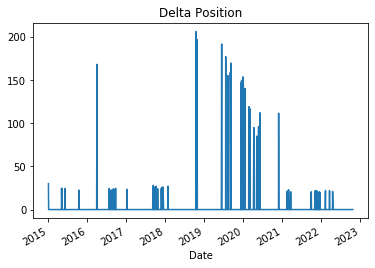

In [ ]:
pair_corr_trade['delta'].plot()
plt.title("Delta Position")
plt.show()

### backtest 

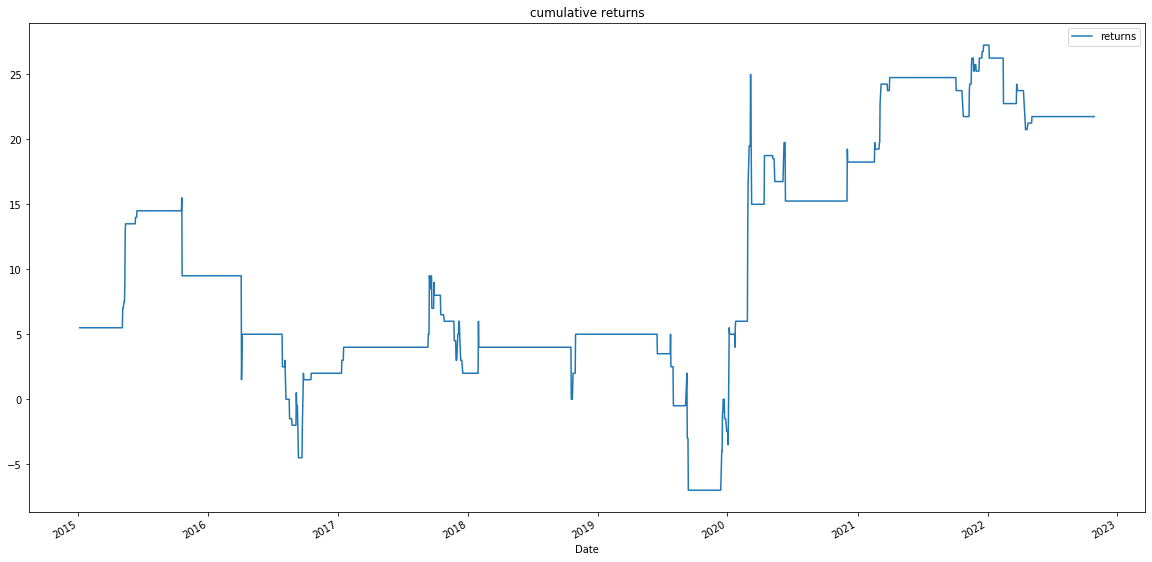

In [ ]:
pair_corr_trade['returns'] = ((KBANK_p - KBANK_p.shift(1))/KBANK_p.shift(1))*pair_corr_trade['KBANK_position'].shift(1) + ((BBL_p - BBL_p.shift(1))/BBL_p.shift(1))*pair_corr_trade['BBL_position'].shift(1)
pair_corr_trade['returns'].sum()

eq = pair_corr_trade[['returns']].cumsum().copy()
eq.plot(figsize=(20,10))
plt.title("cumulative returns")
plt.legend()
plt.show()

## Kalman Filter

In [ ]:
ticker = 'BBL.BK KBANK.BK'

df_ori = yf.download(ticker, start='2015-01-01',adjust=True)
df = df_ori['Close'].copy()
df.head()

[*********************100%***********************]  2 of 2 completed


,BBL.BK,KBANK.BK
Date,,
2015-01-05,190.0,220.0
2015-01-06,189.5,214.0
2015-01-07,191.5,218.0
2015-01-08,192.0,228.0
2015-01-09,190.0,229.0


In [ ]:
symbol1,symbol2 = 'BBL.BK','KBANK.BK' 
df1 = df['BBL.BK'].copy()
df2 = df['KBANK.BK'].copy()
ratio = df['BBL.BK']/df['KBANK.BK']

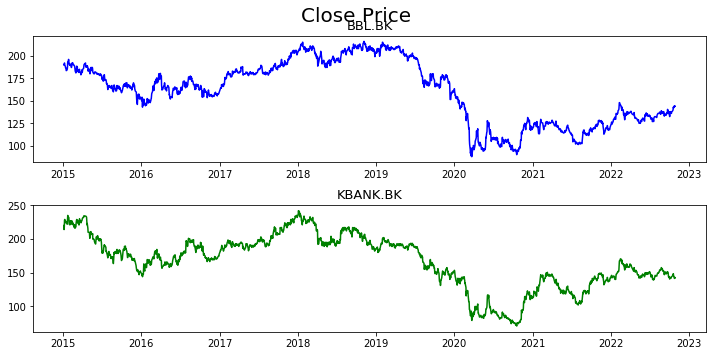

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(10,5))

fig.suptitle('Close Price', size=20)

axes[0].plot(df['BBL.BK'], color='blue')
axes[0].set_title('BBL.BK', fontsize=13)

axes[1].plot(df['KBANK.BK'], color='green')
axes[1].set_title('KBANK.BK', fontsize=13)

plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

In [ ]:
kf = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = 0,
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.0001)  

In [ ]:
kf

In [ ]:
mean, cov = kf.filter(ratio.values)
mean

array([[0.43181818],
       [0.58307029],
       [0.65693681],
       ...,
       [0.90758369],
       [0.90857283],
       [0.90958728]])

In [ ]:
cov

array([[[0.5       ]],

       [[0.33337777]],

       [[0.25008124]],

       ...,

       [[0.00995012]],

       [[0.00995012]],

       [[0.00995012]]])

In [ ]:
mean, cov = kf.filter(ratio.values)
mean, std = mean.squeeze(), np.std(cov.squeeze())

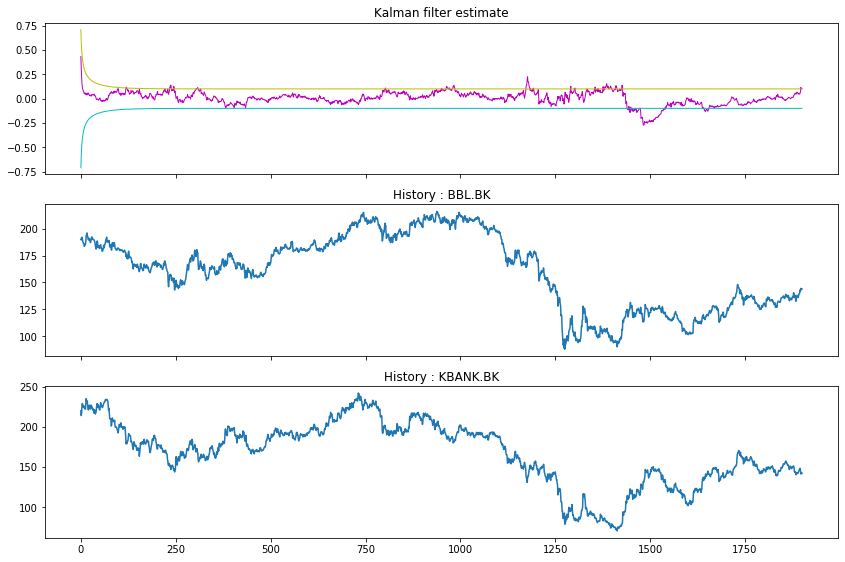

In [ ]:
plt.rcParams["figure.figsize"] = (12,8)
fig, axs = plt.subplots(3,sharex=True)

fig.tight_layout(pad=2.0)
axs[0].plot(ratio.values - mean, 'm', lw=1)
axs[0].plot(np.sqrt(cov.squeeze()), 'y', lw=1)
axs[0].plot(-np.sqrt(cov.squeeze()), 'c', lw=1)
axs[0].set_title('Kalman filter estimate')

axs[1].set_title('History : '+symbol1)
axs[1].plot(df['BBL.BK'].values)

axs[2].set_title('History : '+symbol2)
axs[2].plot(df['KBANK.BK'].values)

plt.show()

In [ ]:
data = pd.DataFrame()
data[symbol1] = df['BBL.BK']
data[symbol2] = df['KBANK.BK']
data['ratio'] = ratio

data.head(5)

,BBL.BK,KBANK.BK,ratio
Date,,,
2015-01-05,190.0,220.0,0.863636
2015-01-06,189.5,214.0,0.885514
2015-01-07,191.5,218.0,0.878440
2015-01-08,192.0,228.0,0.842105
2015-01-09,190.0,229.0,0.829694


In [ ]:
#data = data[data.index>'2010-01-01']

# Use the observed values of the price to get a rolling mean and z_score
mean, cov =  kf.filter(data['ratio'].values)
data['mean'] = mean.squeeze()
data['cov'] = cov.squeeze()
data['std'] = np.sqrt(data['cov'])
data = data.dropna()

data['ma'] = data['ratio'].rolling(5).mean()
data['z_score'] = (data['ma'] - data['mean'])/data['std']

# Initialise positions as zero
data['position_1'] = np.nan
data['position_2'] = np.nan

# Generate buy, sell and square off signals as: z<-1 buy, z>1 sell and -1<z<1 liquidate the position
for i in range (data.shape[0]):
  if data['z_score'].iloc[i] < -1:
    data['position_1'].iloc[i] = 1
    data['position_2'].iloc[i] = -round(data['ratio'].iloc[i],0)
  if data['z_score'].iloc[i] > 1:
    data['position_1'].iloc[i] = -1
    data['position_2'].iloc[i] = round(data['ratio'].iloc[i],0)
  if (abs(data['z_score'].iloc[i]) < 1) & (abs(data['z_score'].iloc[i]) > 0):

    #ถ้าอยากมีสถานะเพิ่ม ให้ใช้ data['position_1'].iloc[i-1]
    #ถ้าไม่อยากมีสถานะเพิ่ม เมื่อราคาเคลื่อนในกรอบ ให้กำหนดเป็นศูนย์
    data['position_1'].iloc[i] = 0#data['position_1'].iloc[i-1]
    data['position_2'].iloc[i] = 0#data['position_1'].iloc[i-1]
    
# Calculate returns 
data['returns'] = ((data[symbol1]-data[symbol1].shift(1))/data[symbol1].shift(1))*data['position_1'].shift(1)+ ((data[symbol2]-data[symbol2].shift(1))/data[symbol2].shift(1))*data['position_2'].shift(1)
data['returns'].sum()

0.1835873284809162

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc905c4b210>],
      dtype=object)

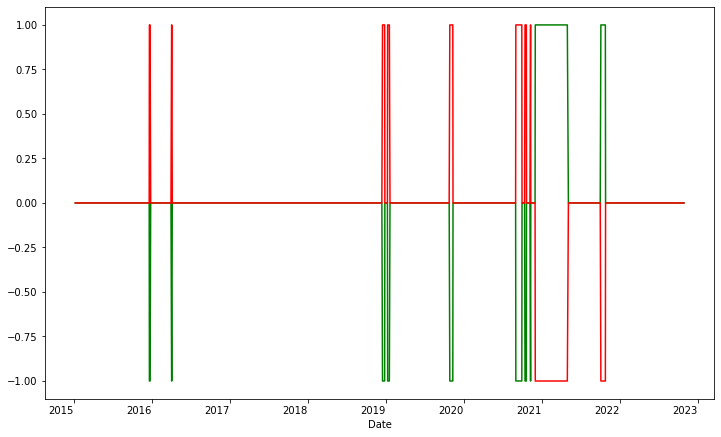

In [ ]:
data['position_1'].plot(color='green')
data['position_2'].plot(subplots=True,color='red')

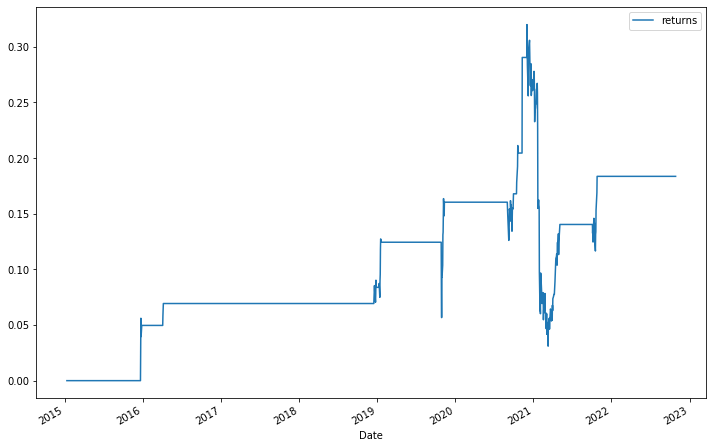

In [ ]:
#ส่วนของ Equity Curve
eq = data[['returns']].cumsum().copy()
eq.plot()

In [ ]:
len(eq),len(df1)

(1901, 1901)

### backtest

In [ ]:
#!pip install ffn
import ffn

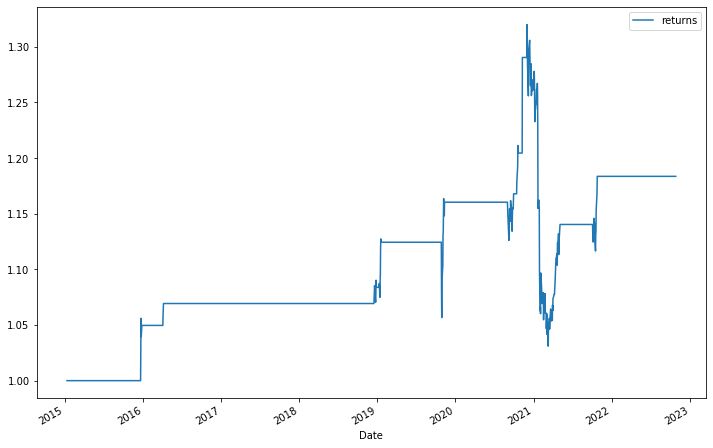

In [ ]:
eq = eq+1 #เพื่อไม่ให้ค่าเป็นศูนย์  ทดสอบโดยโยน equity curve เข้าไป
eq.plot()

In [ ]:
#ทดสอบ stat กับ equity curve 
perf = eq.calc_stats()
perf.set_riskfree_rate(0.015)
print(perf.display())

Stat                 returns
-------------------  ----------
Start                2015-01-12
End                  2022-10-28
Risk-free rate       1.50%

Total Return         18.36%
Daily Sharpe         0.14
Daily Sortino        0.22
CAGR                 2.19%
Max Drawdown         -21.89%
Calmar Ratio         0.10

MTD                  0.00%
3m                   0.00%
6m                   0.00%
YTD                  0.00%
1Y                   0.00%
3Y (ann.)            1.72%
5Y (ann.)            2.05%
10Y (ann.)           -
Since Incep. (ann.)  2.19%

Daily Sharpe         0.14
Daily Sortino        0.22
Daily Mean (ann.)    2.47%
Daily Vol (ann.)     6.78%
Daily Skew           0.61
Daily Kurt           87.95
Best Day             7.13%
Worst Day            -5.82%

Monthly Sharpe       0.13
Monthly Sortino      0.19
Monthly Mean (ann.)  2.43%
Monthly Vol (ann.)   7.00%
Monthly Skew         -1.96
Monthly Kurt         21.45
Best Month           7.13%
Worst Month          -12.95%

Yearly Sharp